Analyze and plot killing curve data. 

In [1]:
# load necessary modules #

import sys
sys.path.append('functions/')
import pandas as pd
import numpy as np
import griess as gr
import bmgdata as bd
import matplotlib.pyplot as plt
import glob
import denitfit as dn
import pickle
import copy

def load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,pidx):
    plate_meta = pd.read_csv(meta_fn,index_col=0).dropna()  #import metadata and drop rows with any empty elements
    #reads in files and infers concentrations from absorbances using standard curve parameters ("fit")
    #assumes filenames are in the order t1, t2, t3, ...
    plate_no2 = pd.DataFrame()
    plate_no3 = pd.DataFrame()
    for i in range(0,len(no2_fns)):
        #print(no2_fns)
        no2 = gr.read_griess(meta_fn,data_fn=no2_fns[i])
        if no2no3_540_fns == None:
            no2no3 = None
        else:
            no2no3 = gr.read_griess(meta_fn,data_540_fn=no2no3_540_fns[i],data_900_fn=no2no3_900_fns[i])
        data = gr.invert_griess(no2,fit,no2no3)
        plate_no2 = plate_no2.append(data["NO2"].rename("t"+str(i+1)))
        plate_no3 = plate_no3.append(data["NO3"].rename("t"+str(i+1)))
    
    #adds a prefix to the column names to indicate what plate the sample belongs to
    plate_meta  = ((plate_meta.transpose()).add_prefix("p" + str(pidx) + "_")).transpose()
    plate_no2 = plate_no2.add_prefix("p" + str(pidx) + "_")
    plate_no3 = plate_no3.add_prefix("p" + str(pidx) + "_")
    
    #transposes data frame so columns are time points and rows are wells
    plate_no2 = plate_no2.transpose()
    plate_no3 = plate_no3.transpose()
    
    return [plate_meta,plate_no2,plate_no3]







/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


fit griess assay model using standard curves

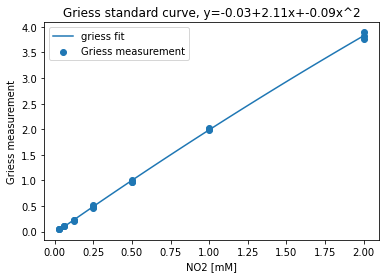

In [3]:

std_meta_fn = "data/standards_metadata.csv"
#print(std_meta_fn)
std_no2_fn = glob.glob("data/KC_NO2_standard*.csv")[0]
std_no2no3_fn = None
#std_no2no3_540_fn = '/home/kyle/microbial_ecology/pathway_splitting/data/fine_scale_pH_enrichment_10072021/KC_NO2NO3_SCAN_540_10212021_standard_prgb_init_20211022_221717.CSV'

std_no2no3_540_fn = glob.glob("data/*_standard*_Absorbance_KC_NO2NO3_540_SCAN.CSV")[0]
#print(std_no2no3_540_fn)
std_no2no3_900_fn = glob.glob("data/*_standard*_Absorbance_KC_NO2NO3_900_SCAN.CSV")[0]
#std_no2no3_900_fn = '/home/kyle/microbial_ecology/pathway_splitting/data/fine_scale_pH_enrichment_10072021/KC_NO2NO3_SCAN_900_10212021_standard_prgb_init_20211022_221717.CSV'


#print(std_no2no3_900_fn)
fit = gr.fit_griess(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
[[no2_blank_dont_use,no2no3_blank_dont_use], g_fit_dont_use, v_fit] = fit
#print(fit)
#print(v_fit)
gr.plot_griess_fit(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.savefig('griess_standard_curve.png')

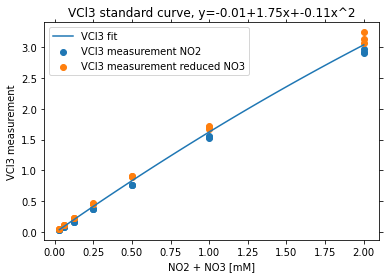

In [4]:
plt.cla()
gr.plot_vcl_fit(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.savefig('vcl3_standard_curve.png')

Now load CFU count and metabolite data. 

In [6]:

import pandas

data = pandas.read_csv('data/CFU_counts.csv')
#print(data)
#print(data["time_hrs"])

t_cfus = data["time_mins"].values/60
t = []
for i in range(len(t_cfus)):
    t.append(t_cfus[i])

#Load plate 1 time series and endpoint OD
meta_fn = "data/plate1_metadata.csv"
#od_fn = glob.glob("/Users/kylecrocker/Documents/Research/microbial_ecology/load_denit_data/data_07152021/*OD_endpoint*plate1*")[0]
no2_fns = sorted(glob.glob("data/*NO2_*drex_3_c2_*t*"))
#print(no2_fns)
no2no3_540_fns = sorted(glob.glob("data/*drex_3_*c2_*t*_*NO2NO3_540_SCAN.CSV"))
#print(no2no3_540_fns)



no2no3_900_fns = sorted(glob.glob("data/*drex_3_*c2_*t*_*NO2NO3_900_SCAN.CSV"))
#print(no2no3_900_fns)

[plate1_meta,plate1_no2,plate1_no3]=load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,1)

#rename plate 1 info to be consistent with the rest of the code
merged_no2 = plate1_no2
merged_no3 = plate1_no3
merged_meta = plate1_meta


#correct for evaporation using control
idx = (merged_meta["strain_ID"]=="blank") & (merged_meta["NO3_0"]==1)
no3_corr = merged_no3.loc[idx].median().values[0]/merged_no3.loc[idx].median().values.reshape(-1,1)
no2_corr = merged_no2.loc[idx].median().values[0]/merged_no2.loc[idx].median().values.reshape(-1,1)

#apply correction factors to all wells
idx = (merged_meta["NO3_0"]<3)  #all of them 

merged_no3.loc[idx] = merged_no3.loc[idx].multiply(np.transpose(no3_corr), axis='columns')
merged_no2.loc[idx] = merged_no2.loc[idx].multiply(np.transpose(no2_corr),axis='columns')


In [7]:
#get strains
strain_IDs = np.setdiff1d(np.unique(merged_meta["strain_ID"]),['blank'])
all_experiments_10 = []

#load OD data
OD_filename = 'data/KC_OD600_NUNC_deathcurve_c2_OD_endpt_090922_220909_162344.csv'
OD_meta       = pd.read_csv(meta_fn,index_col=0).dropna(how='all')  #import metadata
OD_data_frame = bd.read_abs_endpoint(OD_filename)
OD_data_frame = OD_data_frame[OD_data_frame.index.isin(OD_meta.index)]

dilution_factor = 8.0
#For each strain_ID, identify wells corresponding to each experimental condition and put into experiments object
for j in range(0,len(strain_IDs)):
    cond = np.array([[0,0,6],[0,0.5,6],[0,1,6],[0,2,6],[0,0,7.3],[0,2,7.3]])
    #load data into a list of experiment objects
    experiments = []
    for i in range(0,cond.shape[0]):
        blank_idx = (OD_meta["strain_ID"] == 'blank')
        blank_val = OD_data_frame[blank_idx].values
        OD_idx = ((OD_meta["strain_ID"]==strain_IDs[j]) & (OD_meta["NO3_0"]==cond[i,0]) & (OD_meta["NO2_0"]==cond[i,1]) & (OD_meta["pH"]==cond[i,2])& (OD_meta["succinate"]==4))
        idx = ((merged_meta["strain_ID"]==strain_IDs[j]) & (merged_meta["NO3_0"]==cond[i,0]) & (merged_meta["NO2_0"]==cond[i,1])& (merged_meta["pH"]==cond[i,2])& (merged_meta["succinate"]==4))
        ID = strain_IDs[j]
        A0 = cond[i,0]
        A = merged_no3.loc[idx].values
        I0 = cond[i,1]
        I = merged_no2.loc[idx].values
        pH = cond[i,2]
        N0 = 0.04/dilution_factor
        Nend = OD_data_frame[OD_idx].values - np.mean(blank_val) 
        phen = 'Nar/Nir'
        succ_conc = 4
        experiments.append(dn.enrichment_experiment(ID, phen, N0, Nend, A0, A, I0, I, t, succ_conc, pH, endpoint_pH = None))   
    all_experiments_10.append(experiments)

pickle_out = open("CFU_dyn.pkl","wb")
pickle.dump(all_experiments_10, pickle_out)
pickle_out.close()

Next, plot CFU dynamics and perform log-linear fits. Plot metabolite dynamics on the same axes. 

R
I0_
fit value is:
-0.013+-0.004
I05_
fit value is:
0.004+-0.001
I1_
fit value is:
0.001+-0.001
I2_
fit value is:
-0.007+-0.001
P
I0_
fit value is:
-0.008+-0.004
I05_
fit value is:
0.001+-0.002
I1_
fit value is:
-0.023+-0.004
I2_
fit value is:
-0.039+-0.004


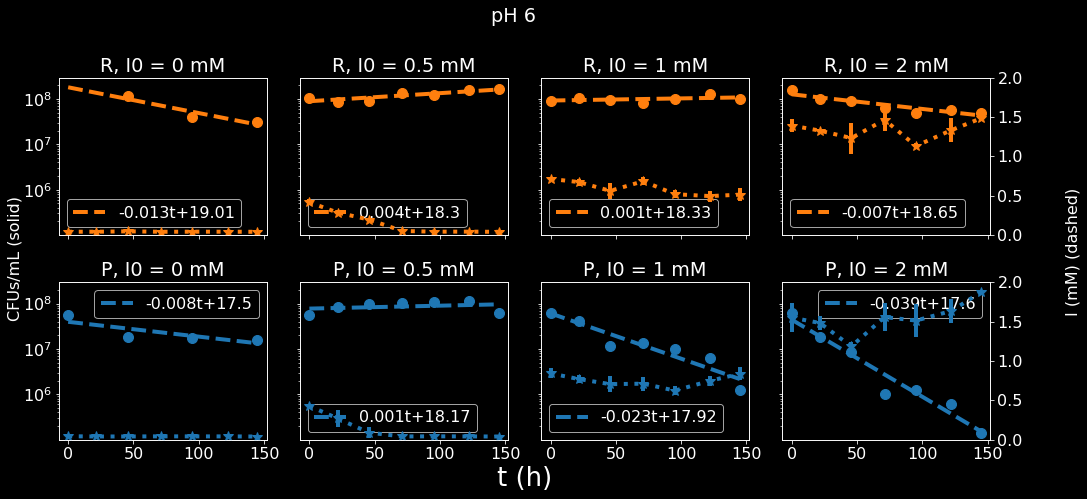

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import pandas
import sys
sys.path.append('functions/')
import cfu_analysis as ca

import warnings
warnings.filterwarnings('ignore')

markersize = 10
linewidth = 4
alpha = 1

#load raw CFU count data
data = pandas.read_csv('data/CFU_counts.csv')

ts = data["time_mins"].values/60.0

strains = ['R', 'P']
strains_low = ['r', 'p']
strain_names = ['NapA', 'NarG']
colors = ['tab:orange', 'tab:blue']
symbols = ['o', 'o']

dilution = [1,2,3,4,5,6]
dilution_name = ['d1','d2','d3', 'd4', 'd5','d6']
Istrings = ['I0_','I05_', 'I1_', 'I2_' ]
Is = [0,0.5,1,2]

#factor to convert counts in 10 uL sample to concentration
conv = 10 / 0.01 #10 uL / 0.01 mL = 1 

cfus = np.zeros((len(strains), len(Is), len(ts)))
cfu_stds = np.zeros((len(strains), len(Is), len(ts)))


plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 16})
fig, axs = plt.subplots(len(strains),len(Is),figsize=(15,7), sharex = True, sharey = True)
fig.tight_layout()


# loop through strains and nitrite conditions: R = RH Nap+ and P = PD Nar+
for i in range(len(strains)):
    print(strains[i])
    for j in range(len(Is)):
        avg_array = []
        std_array = []
        print(Istrings[j])
        
        # calculate CFU concentration by weighted average over dilution factors
        for k in range(len(dilution)):
            reps = []
            for col in data.columns:
                if (strains[i] in col) and (Istrings[j] in col) and (dilution_name[k] in col) and ('pH6' in col):
                    reps.append(data[col].values)
                    
            reps = np.asarray(reps)
            avgs = []
            stds = []
        
            for l in range(len(ts)):
                try:
                    avg, std = ca.get_avg_std(reps.T[l])
                except:
                    avg = np.nan
                    std = np.nan
                avgs.append(avg)
                stds.append(std)
            avgs = np.asarray(avgs)* conv * (10**dilution[k])
            stds = np.asarray(stds) * conv * (10**dilution[k])
            avg_array.append(avgs)
            std_array.append(stds)
        avg_array = np.asarray(avg_array)
        std_array = np.asarray(std_array)
        avgs = []
        stds = []
        for m in range(len(ts)):
            avg_counts = avg_array.T[m][avg_array.T[m]>0]
            std_counts = std_array.T[m][avg_array.T[m]>0]
            avg, std = ca.combine_avgs_weighted(avg_counts, std_counts)
            avgs.append(avg)
            stds.append(std)
        avgs = np.asarray(avgs)
        
        # perform log-linear fit to infer death rate
        coef, cov = np.polyfit(ts[~np.isnan(avgs)],np.log(avgs[~np.isnan(avgs)]),1, cov=True)
        poly1d_fn = np.poly1d(coef)
        fit_std = np.sqrt(np.diag(cov))
        
        #print fit value
        print('fit value is:')
        print(str(round(coef[0],3)) + '+-' + str(round(fit_std[0], 3)))
        
        # poly1d_fn is now a function which takes in x and returns an estimate for y
        axs[i][j].plot(ts, np.exp(poly1d_fn(ts)), '--', color = colors[i], linewidth = linewidth, label = str(round(coef[0],3))+'t+'+str(round(coef[1],2))) #'--k'=black dashed line, 'yo' = yellow circle marker
        axs[i][j].errorbar(ts, avgs, yerr = stds, ls = '-',  marker = symbols[i], markersize = markersize, color = colors[i], ecolor = colors[i], linewidth = 0)#, label = strain_names[i]+' mon')
        cfus[i,j,:] = avgs
        cfu_stds[i,j,:] = stds
        axs[i][j].set_yscale('log')
        axs[i][j].set_title(strains[i]+', I0 = ' + str(Is[j]) + ' mM')
        
        
        # plot metabolite dynamics on the same axis
        ax2 = axs[i][j].twinx()
        for experiments in all_experiments_10:
            for experiment in experiments:
                if experiment.ID == strains_low[i] and experiment.A0 == 0 and experiment.I0 == Is[j] and experiment.pH == 6:

                    ax2.errorbar(experiment.t, np.mean(experiment.I, axis = 0), yerr = np.std(experiment.I, axis = 0), markersize = markersize, marker = '*',linestyle = ':', linewidth = linewidth, alpha = alpha, color = colors[i], ecolor = colors[i])
                    experiment.N = avgs
                    avg, std = ca.CFUs_per_OD(avgs[0], stds[0], experiment.N0, 0)
                    avg, std = ca.CFUs_per_OD(avgs[-1], stds[-1], np.mean(experiment.Nend, axis=0), np.std(experiment.Nend, axis=0))
                    ax2.set_ylim([0,2])
                if j == 3:
                    ax2.axes.yaxis.set_visible(True)
                else:
                    ax2.axes.yaxis.set_visible(False)
        axs[i][j].legend()

plt.suptitle('pH 6')                  
fig.add_subplot(111, frameon=False)
fig.tight_layout()

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

np.savez('processed_CFU_data', ts = ts, strains = strain_names, Is = Is, cfus = cfus, cfu_stds = cfu_stds)

plt.xlabel("t (h)", fontsize = 26)
plt.ylabel('CFUs/mL (solid)')
plt.text(1.08, 0.35, 'I (mM) (dashed)', rotation = 'vertical')
plt.show()


Plot metabolite dynamics nicely for paper. 

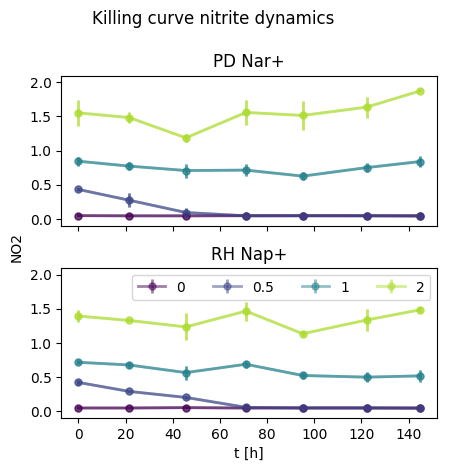

In [9]:
from matplotlib.pyplot import cm

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), ncol = 4)


plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8
plt.style.use('default')

markersize = 5
linewidth = 2
alpha = 0.5
fig, axs = plt.subplots(2,1,figsize=(5,5), sharex = True, sharey = True)
cmap = cm.get_cmap('viridis')
for i in range(len(strain_names)):
    for j in range(len(Is)):
        for experiments in all_experiments_10:
            for experiment in experiments:
                color_val = cmap((Is[j]*7.0/8.0)/(2))
                if experiment.ID == 'p' and experiment.A0 == 0 and experiment.I0 == Is[j] and experiment.pH == 6:
                    #print('hit 1')
                    axs[0].errorbar(experiment.t, np.mean(experiment.I, axis = 0), yerr = np.std(experiment.I, axis = 0), markersize = markersize, marker = 'o', ecolor = color_val, color = color_val, linewidth = linewidth, alpha = alpha)                                                                                                                                                                                
                elif experiment.ID == 'r' and experiment.A0 == 0 and experiment.I0 == Is[j] and experiment.pH == 6:
                    axs[1].errorbar(experiment.t, np.mean(experiment.I, axis = 0), yerr = np.std(experiment.I, axis = 0), markersize = markersize, marker = 'o', ecolor = color_val, color = color_val, linewidth = linewidth, alpha = alpha, label = str(Is[j]))
                    #print('hit 2')

legend_without_duplicate_labels(axs[1])
axs[0].set_ylim([-0.1, 2.1])
axs[1].set_ylim([-0.1, 2.1])

axs[0].set_title('PD Nar+')
axs[1].set_title('RH Nap+')

plt.suptitle('Killing curve nitrite dynamics')
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes                                                                                                                                                                         
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)                                                                                                                                                                                       
plt.xlabel("t [h]")
plt.ylabel('NO2')                                                                                                                                                                         
fig.tight_layout()                                                                                                                                                                      
plt.savefig('SI_fit_met_dyn.svg')
plt.savefig('SI_fit_met_dyn.png')
plt.show()